- sgd comparision
- Parameter sensitivity
- delta

In [108]:
import os
import copy
import numpy as np
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader

%matplotlib inline

data_path = os.environ['MS_DATASETS_PATH']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
plt.rcParams["figure.figsize"] = (25, 4)

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                ])


ds_train = CIFAR10(root=f"{data_path}/CIFAR10", train=True, transform=transform)
ds_test = CIFAR10(root=f"{data_path}/CIFAR10", train=False, transform=transform)

print('Number of training images:', len(ds_train))
print('Number of test images:', len(ds_test))

test_loader = DataLoader(ds_test, batch_size=len(ds_test), shuffle=False)
test_X, test_y = (x.to(device) for x in next(iter(test_loader)))

Number of training images: 50000
Number of test images: 10000


In [153]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Adam(Optimizer):
    r"""Implements Adam algorithm.

    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                state["grads_nom"] = math.sqrt(bias_correction2) * exp_avg
                state["grads_denom"] = bias_correction1 * denom
                state["grads"] = state["grads_nom"] / state["grads_denom"]

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [66]:
import torch
from torch.optim.optimizer import Optimizer, required


class SGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf

    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.

        Considering the specific case of Momentum, the update can be written as

        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v

        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.

        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form

        .. math::
             v = \rho * v + lr * g \\
             p = p - v

        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)
                self.state[p]["grads"] = d_p

        return loss

In [67]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 15, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(15, 10, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(10, 5, kernel_size=5),
            nn.ReLU(),
        )
        
        conv_out = np.prod(self.conv(torch.Tensor(1, 3, 32, 32)).shape)
        self.fnn = nn.Sequential(
            nn.Linear(conv_out, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
        
    def forward(self, X):
        out = self.conv(X)
        out = out.view(len(out), -1)
        out = self.fnn(out)
        return out
     
CNN()

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 10, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 5, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (fnn): Sequential(
    (0): Linear(in_features=2000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [158]:
def evaluate(model, X, y) -> (float, float):
    """:return: loss, acc"""
    out = model(X)
    _, preds = torch.max(out.data, 1)
    correct = (preds == y).sum().item()
    acc = correct / len(y)
    loss = criterion(out, y).detach().cpu().item()
    return loss, acc


def train(model, optimiser) -> dict:
    n_epochs = 5
    batch_size = 128
    criterion = nn.CrossEntropyLoss()

    logs = defaultdict(list)
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

    for _ in range(n_epochs):

        for batch_ix, (batch_X, batch_y) in enumerate(train_loader):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            model.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimiser.step()

            if batch_ix % 10 == 0:
                logs["train_loss"].append(loss.detach().cpu().item())
                test_loss, test_acc = evaluate(model, test_X, test_y)
                logs["test_loss"].append(test_loss)
                logs["test_acc"].append(test_acc)

            p = next(iter(model.conv[4].parameters()))
            random_grad = optimiser.state[p]["grads"][0,0,0,0].item()
            logs["random_grad"].append(random_grad)
            if "grads_nom" in optimiser.state[p]:
                logs["random_grad_nom"].append(optimiser.state[p]["grads_nom"][0,0,0,0].item())
                logs["random_grad_denom"].append(optimiser.state[p]["grads_denom"][0,0,0,0].item())
    return logs
        
    


In [159]:
base_model = CNN()

lr_adam = 1e-4
model = copy.deepcopy(base_model).to(device)
optimiser = Adam(model.parameters(), lr=lr_adam)
logs_adam = train(model, optimiser)

lr_sgd = 1e-2
model = copy.deepcopy(base_model).to(device)
optimiser = SGD(model.parameters(), lr=lr_sgd, momentum=0.9)
logs_sgd = train(model, optimiser)

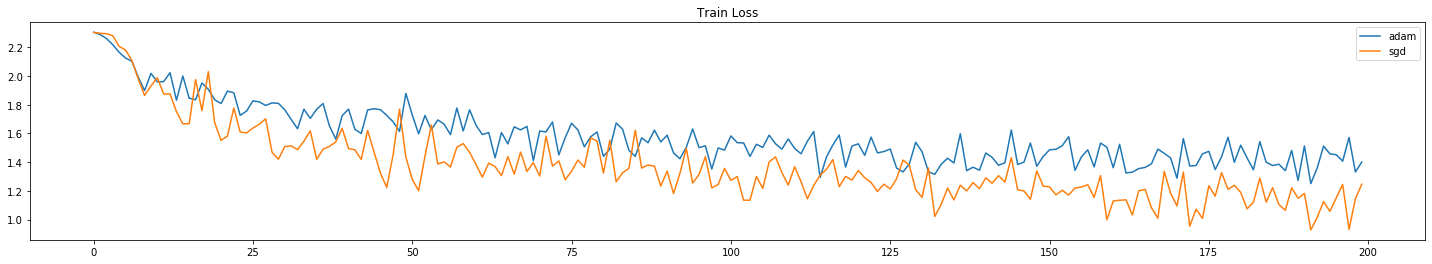

In [156]:
# plt.title("Test Loss")
# plt.plot(logs_adam["test_loss"], label="adam") 
# plt.plot(logs_sgd["test_loss"], label="sgd") 
# plt.legend()
# plt.show()

# plt.title("Test Acc")
# plt.plot(logs_adam["test_acc"], label="adam") 
# plt.plot(logs_sgd["test_acc"], label="sgd") 
# plt.legend()
# plt.show()

plt.title("Train Loss")
plt.plot(logs_adam["train_loss"], label="adam") 
plt.plot(logs_sgd["train_loss"], label="sgd") 
plt.legend()
plt.show()

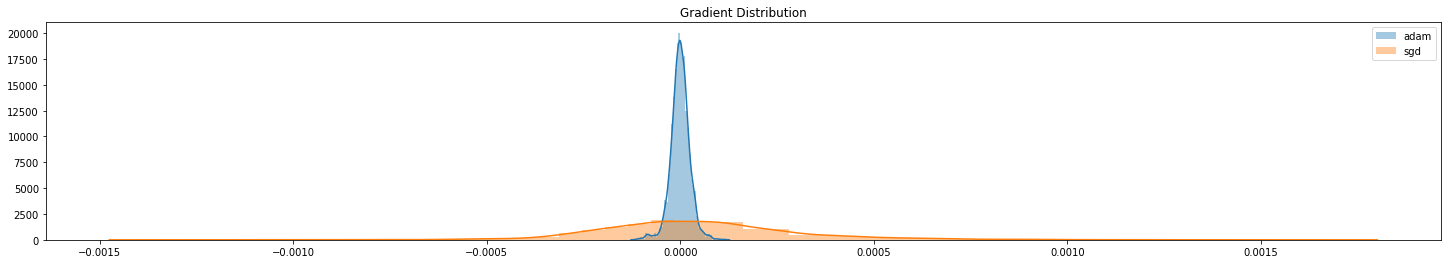

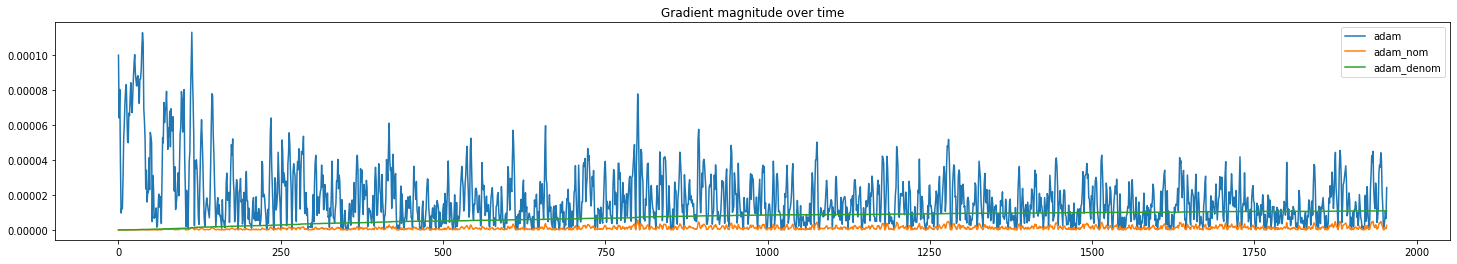

In [161]:

plt.title("Gradient Distribution")
sns.distplot(np.array(logs_adam["random_grad"]) * lr_adam, label="adam") 
sns.distplot(np.array(logs_sgd["random_grad"]) * lr_sgd, label="sgd") 
plt.legend()
plt.show()

plt.title("Gradient magnitude over time")
plt.plot(np.abs(logs_adam["random_grad"]) * lr_adam, label="adam")
plt.plot(np.abs(logs_adam["random_grad_nom"]) * lr_adam, label="adam_nom")
plt.plot(np.abs(logs_adam["random_grad_denom"]) * lr_adam, label="adam_denom")
#plt.plot(np.abs(logs_sgd["random_grad"]) * lr_sgd, label="sgd")
plt.legend()
plt.show()